In [1]:
import test_yolo
import json
import numpy as np
import traceback


A module that was compiled using NumPy 1.x cannot be run in
NumPy 2.1.1 as it may crash. To support both 1.x and 2.x
versions of NumPy, modules must be compiled with NumPy 2.0.
Some module may need to rebuild instead e.g. with 'pybind11>=2.12'.

If you are a user of the module, the easiest solution will be to
downgrade to 'numpy<2' or try to upgrade the affected module.
We expect that some modules will need time to support NumPy 2.

Traceback (most recent call last):  File "c:\Python310\lib\runpy.py", line 196, in _run_module_as_main
    return _run_code(code, main_globals, None,
  File "c:\Python310\lib\runpy.py", line 86, in _run_code
    exec(code, run_globals)
  File "C:\Users\michi\AppData\Roaming\Python\Python310\site-packages\ipykernel_launcher.py", line 18, in <module>
    app.launch_new_instance()
  File "C:\Users\michi\AppData\Roaming\Python\Python310\site-packages\traitlets\config\application.py", line 1075, in launch_instance
    app.start()
  File "C:\Users\michi\AppData\

In [2]:
path = test_yolo.mypath + "\\cars.json"

def clean_data(data):
    paths = {}
    
    for i, dato in enumerate(data):
        immagine = dato["image"]
        if list(paths.keys()).count(immagine) == 0:
            paths[immagine] = [i]
        else:
            paths[immagine].append(i)
    
    puliti = []

    for key, val in list(paths.items()):
        numeri = set()
        total_expected = set()
        for idx in val:
            numbers = data[idx]["numbers"]
            for num in numbers:
                bounds = num["bounds"]
                expected = num["expected"]

                if expected not in total_expected:
                    numdict = {"bounds" : bounds, "expected" : expected}
                    numeri.add(json.dumps(numdict))
                    total_expected.add(expected)

        lista = [json.loads(i) for i in numeri]

        puliti.append({
            "image" : key,
            "numbers" : lista
        })
    return puliti

        

with open(path, "r") as fi:
    read = fi.read()
    json_data = json.loads(read)
    json_data = clean_data(json_data)

In [3]:
import cv2
import matplotlib.pyplot as plt
import pytesseract
from ipywidgets import interactive, IntSlider, FloatSlider
from IPython.display import display

def tagliaimmagine(height1 = 0, height2 = 200):
    img = cv2.imread(json_data[4]["image"])

    cut = img[height1:height2]
    plt.imshow(cut)
    plt.show()

height1 = IntSlider(min=0, max=1000, value=400)
height2 = IntSlider(min=100, max=1000, value=815)

cutviewer = interactive(tagliaimmagine, height1=height1, height2=height2)
display(cutviewer)

interactive(children=(IntSlider(value=400, description='height1', max=1000), IntSlider(value=815, description=…

In [4]:


def calc_epsilon(image, cut_img, e = 0.07110000000000001):
    contours, _ = cv2.findContours( image, cv2.RETR_TREE, cv2.CHAIN_APPROX_SIMPLE)
    
    colored = cv2.cvtColor(image, cv2.COLOR_GRAY2RGB)

    colored = cv2.drawContours(colored, contours, -1, (255,0,0), 1)

    approxed = []

    for contour in contours:
        epsilon = e * cv2.arcLength(contour, False)
        approx = cv2.approxPolyDP(contour, epsilon, True)


        x, y, w, h = cv2.boundingRect(approx)

        areaRect = cv2.minAreaRect(approx)
        angle = - (areaRect[2] % 10) / 2

        area = cv2.contourArea(approx)

        if w > 30 and w < 100 and h > 20 and h < 100 and area > 600:
            colored = cv2.drawContours(colored, [approx], -1, (0,255,0), 2)
            cut = cut_img[y:y+h, x:x+w]

            print("angle:", angle)

            #print(len(approx), area)


            rotation_mat = cv2.getRotationMatrix2D((w // 2, h // 2), angle, 1)
            result = cv2.warpAffine(cut, rotation_mat, cut.shape[1::-1], flags=cv2.INTER_NEAREST, borderValue=(255,255,255))


            approxed.append(result)
    
        """plt.imshow(colored)
        plt.title("Possibili adesivi")
        plt.show()"""

    return approxed


def find(start,area_cutoff = 100, h1 = 98, s1 = 0, v1 = 127, h2 = 155, s2 = 90, v2 = 255,e = 0.07110000000000001, lab_thres = 200):

    
    amount = 1
    for i in range(start, min(start + amount, len(json_data))):
        image =  cv2.imread(json_data[i]["image"])
        thres = test_yolo.new_thres(image, h1, s1, v1, h2, s2, v2)

        print("Immagine:", json_data[i]["image"])
        for j,number in enumerate(json_data[i]["numbers"]):
            x1,y1,x2,y2 = number["bounds"]
            
            width = x2 - x1
            height = y2 - y1
            print(width / height)

            cut = thres[y1:y2, x1:x2]

            if width / height >= 2:
                
                start = x1 + (width // 3)
                last_quarter = x2 - (width // 5)

                top = height // 5

                cut = thres[y1 + top:y2, start:x2]
                cut_img = image[y1:y2, x1:x2]
            plt.imshow(cut, "gray")
            plt.show()

            text = pytesseract.image_to_string(cut, config=test_yolo.custom_oem_psm_config)
            text = text.strip()
            print("Immagine intera:", text)

            squares = calc_epsilon(cut, cut, e)
            expected = number["expected"]
            found_numbers = []
            for square in squares:
                (height, width) = square.shape[:2]
                if height / width > 1.1:
                    square = square[height//3:]

                blurred = cv2.GaussianBlur(square, (5, 5), 0)
                # Equalizzazione adattiva dell'istogramma
                clahe = cv2.createCLAHE(clipLimit=2.0, tileGridSize=(8,8))
                enhanced = clahe.apply(blurred)  # Miglioramento del contrasto
                _, enh_thres = cv2.threshold(enhanced, 0, 255, cv2.THRESH_BINARY + cv2.THRESH_OTSU)


                # Creare una copia bianco su nero
                copy = cv2.bitwise_not(enh_thres)

                plt.imshow(copy, "gray")
                plt.show()

                # Trovare tutti i contorni dell'immagine e rimuovere quelli più piccoli (i numeri saranno le macchie più grandi)
                contours, _ = cv2.findContours(copy, cv2.RETR_LIST, cv2.CHAIN_APPROX_NONE)
                print("Found ", len(contours), "contours")

                for c in contours:
                    area = cv2.contourArea(c)

                    if area < area_cutoff:
                        cv2.drawContours(copy, [c], 0, 0, -1)
                    else:
                        for point in c:
                            point = point[-1]
                            if point[0] == 0 or point[0] == copy.shape[1] - 1:
                                cv2.drawContours(copy, [c], 0,0,-1)
                                break

                # Fare tornare l'immagine da bianco su nero a nero su bianco
                result = cv2.bitwise_not(copy)
                plt.imshow(result, "gray")
                plt.show()
                text = pytesseract.image_to_string(result, config=test_yolo.custom_oem_psm_config)
                text = text.strip()

                if text != "":
                    try:
                        text = int(text)
                        found_numbers.append(text)
                        print(f"{text = } = {expected = } ? {text == expected}")
                    except:
                        print(number)



h1 = IntSlider(min=0, max=179, value=0)
s1 = IntSlider(min=0, max=255, value=0)
v1 = IntSlider(min=0, max=255, value=137)

h2 = IntSlider(min=0, max=179, value=179)
s2 = IntSlider(min=0, max=255, value=62)
v2 = IntSlider(min=0, max=255, value=255)
e = FloatSlider(min=0.0001, max=0.1, value=0.07110000000000001, step=0.001)
start = IntSlider(min=0, max=len(json_data) - 4, value=1) #162
area_cutoff = IntSlider(min=0, max=500, value=90)
lab_thres = IntSlider(min=0, max=255, value=200)



viewer = interactive(find,area_cutoff=area_cutoff, start=start, h1=h1, s1=s1,v1=v1,h2=h2,s2=s2,v2=v2,e=e, lab_thres=lab_thres)
display(viewer)

    

interactive(children=(IntSlider(value=1, description='start', max=227), IntSlider(value=90, description='area_…

In [5]:
import numpy as np
from concurrent.futures import ThreadPoolExecutor, as_completed

def merge_contours(contours, threshold):
    while True:
        merged_contours = []
        taken = [False] * len(contours)
        changes = False  # Indica se è stata fatta almeno un'unione

        for i, c1 in enumerate(contours):
            if taken[i]:
                continue
            taken[i] = True
            new_contour = c1

            for j, c2 in enumerate(contours):
                if i != j and not taken[j]:
                    # Bounding box dei contorni
                    x1, y1, w1, h1 = cv2.boundingRect(c1)
                    x2, y2, w2, h2 = cv2.boundingRect(c2)

                    l2r1 = abs(x2 - (x1 + w1)) < threshold
                    l1r2 = abs(x1 - (x2 + w2)) < threshold

                    l1l2 = abs(x2 - (x1)) < threshold
                    r1r2 = abs((x2 + w2) - (x1 + w1)) < threshold

                    t1b2 = abs(y1 - (y2 + h2)) < threshold
                    t2b1 = abs(y2 - (y1 + h1)) < threshold

                    t1t2 = abs(y1 - (y2)) < threshold
                    b1b2 = abs((y1 + h1) - (y2 + h2)) < threshold

                    horiz = (l2r1 or l1r2) or (l1l2 or r1r2)
                    vert = (t1b2 or t2b1) or (t1t2 or b1b2)

                    # Controlla se la distanza è inferiore alla soglia
                    if horiz and vert:
                        new_contour = np.concatenate((new_contour, c2))
                        taken[j] = True
                        changes = True  # Segnala che c'è stato un cambiamento

            merged_contours.append(new_contour) 

        if not changes:
            break  # Esce dal ciclo quando non ci sono più cambiamenti

        contours = merged_contours  # Aggiorna i contorni per il prossimo ciclo

    return contours

def get_largest_contour(contours):
    largest = None
    largest_area = 0
    for c in contours:
        x, y, w, h = cv2.boundingRect(c)
        area = w * h
        if area > largest_area:
            largest_area = area
            largest = c
    return largest

def remove_small(c):
    area = cv2.contourArea(c)

    if area < 85 or area > 570:
        return c
    else:
        return False

def check_points(cwh):

    c, w, h = cwh
    small = remove_small(c)

    if small is not False:
        return small
    else:
        eliminable = False
        distanza_minima = float('inf')
        for point in c:
            point = point[-1]
            x, y, = point
            if x == 0 or x == w - 1 or y == 0:
                eliminable = True
            else:
                distanza = np.sqrt((x - w // 2) ** 2 + (y - h // 2) ** 2)
    
                # Se è la distanza più piccola trovata finora, aggiorna il punto
                if distanza < distanza_minima:
                    distanza_minima = distanza
        if eliminable and distanza_minima > 17:
            return c
    

    return False



def parallel_clean_contours(copy):
    
    h, w = copy.shape[:2]
    contours, _ = cv2.findContours(copy, cv2.RETR_LIST, cv2.CHAIN_APPROX_NONE)
    args = [(c, w, h) for c in contours]
    with ThreadPoolExecutor() as executor:
        results = list(executor.map(check_points, args))

    results = [x for x in results if x is not False]
    
    return cv2.drawContours(copy, results, -1, 0, -1)

def remove_imperfections(image):
    copy = cv2.bitwise_not(image)
    contours, _ = cv2.findContours(copy, cv2.RETR_LIST, cv2.CHAIN_APPROX_NONE)

    
    with ThreadPoolExecutor() as executor:
        results = list(executor.map(remove_small, contours))
    results = [x for x in results if x is not False]
    
    copy =  cv2.drawContours(copy, results, -1, 0, -1)
    return cv2.bitwise_not(copy)


def clean_image(image):
    # Creare una copia bianco su nero
    copy = cv2.bitwise_not(image)
    copy = parallel_clean_contours(copy)
    return cv2.bitwise_not(copy)


def apply_filters(image):

    #fig, ax = plt.subplots(1, 4, figsize=(10, 2))

    # Mostra la finestra (per visualizzazione)
    blurred = cv2.GaussianBlur(image, (5, 5), 0)
    # Equalizzazione adattiva dell'istogramma
    clahe = cv2.createCLAHE(clipLimit=2.0, tileGridSize=(5,5))
    enhanced = clahe.apply(blurred)  # Miglioramento del contrasto
    _, enh_thres = cv2.threshold(enhanced, 0, 255, cv2.THRESH_BINARY + cv2.THRESH_OTSU)

    """ax[0].imshow(image, "gray")
    ax[0].set_title("Ritaglio")

    ax[1].imshow(blurred, "gray")
    ax[1].set_title("Gauss")

    ax[2].imshow(enhanced, "gray")
    ax[2].set_title("Eq. istogramma")

    ax[3].imshow(enh_thres, "gray")
    ax[3].set_title("Otsu")

    plt.show()"""

    return clean_image(enh_thres)


def parallel_check_window(window):
    result = apply_filters(window)

    data = pytesseract.image_to_data(result, config=test_yolo.custom_oem_psm_config, output_type=pytesseract.Output.DICT)
    for i in range(len(data['text'])):
        if int(data['conf'][i]) >= 70:
            return int(data['text'][i])

def map_car(image_cut):
    window_size = 70  # Dimensione della finestra (es. 50x50)

    h, w = image_cut.shape[:2]

    # Coordinate iniziali al centro dell'immagine
    x, y = w // 2, h // 2

    # Movimenti per la spirale (destra, giù, sinistra, su)
    movements = [(1, 0), (0, 1), (-1, 0), (0, -1)]
    step = 1  # Numero di passi da fare prima di cambiare direzione

    # Mantiene traccia della lunghezza della spirale
    length = 1
    direction = 0  # Inizia muovendosi verso destra
    count = 0

    found_numbers = []

    windows = []

    while True:
        # Estrai la finestra corrente
        x_start = max(0, x - window_size // 2)
        y_start = max(0, y - window_size // 2)
        x_end = min(w, x_start + window_size)
        y_end = min(h, y_start + window_size)

        window = image_cut[y_start:y_end, x_start:x_end]


        windows.append(window)
        

        # Muovi la finestra nella direzione corrente
        x += movements[direction][0] * (window_size // 4)
        y += movements[direction][1]* (window_size // 4)
        count += 1

        # Controlla se cambiare direzione
        if count == length:
            count = 0
            direction = (direction + 1) % 4  # Cambia direzione

            # Ogni due direzioni aumenta la lunghezza dello spostamento
            if direction == 0 or direction == 2:
                length += 1

        # Termina se la finestra esce dall'immagine
        if x < -window_size //2 or x >= w + (window_size //2) or y < -(window_size //2) or y >= h + (window_size //2):
            break
    
    with ThreadPoolExecutor() as executor:
        print("Launching parallel sliding windows")
        found_numbers =  list(executor.map(parallel_check_window, windows))
    return [x for x in found_numbers if x != None]


In [6]:

correct = []
wrong = []
not_found = []
too_much_correct = []
too_much_wrong = []
for idx, image in enumerate(json_data):
    img = cv2.imread(image["image"])
    thres = test_yolo.new_thres(img, 0,0,137,179,62,255)
    print(f"checking image {idx}/{len(json_data)}")
    #print(type(image["numbers"]), image["numbers"])
    numbers = [json.dumps(i, sort_keys=True) for i in image["numbers"]]

    numset = set(numbers)

    numbers = [json.loads(i) for i in numset]    

    for number in numbers:
        x1,y1,x2,y2 = number["bounds"]
        width = x2 - x1
        height = y2 - y1

        #print(width / height)
        cut = thres[y1:y2, x1:x2]

        if width / height >= 2 and x1 != 0:
                
            start = x1 + (width // 3)
            last_quarter = x2 - (width // 5)

            top = height // 5

            cut = thres[y1 + top:y2, start:x2]
            
        squares = calc_epsilon(cut, cut)
        expected = number["expected"]
        found_numbers = []
        for square in squares:
            (height, width) = square.shape[:2]
            #print("square ratio", height / width)
            if height / width > 1.1:
                square = square[height//3:]
            
            result = apply_filters(square)
            

            text = pytesseract.image_to_string(result, config=test_yolo.custom_oem_psm_config)
            text = text.strip()
            if text != "":
                try:
                    text = int(text)
                    found_numbers.append(text)
                except:
                    print(number)
        
        if len(found_numbers) == 0 and expected != -1:
            kernel = np.ones((2, 3), np.uint8)  # Kernel orizzontale per rimuovere linee verticali
            cut = cv2.morphologyEx(cut, cv2.MORPH_CLOSE, kernel)
            cut = remove_imperfections(cut)

            contours, _ = cv2.findContours(cut, cv2.RETR_LIST, cv2.CHAIN_APPROX_NONE)

        
            filtered = []
            for c in contours:
                x, y, w, h = cv2.boundingRect(c)
                if h / w >= 1.2:
                    filtered.append(c)


            filtered = merge_contours(filtered, 10)
            while len(found_numbers) == 0 and len(filtered) != 0:

                largest = get_largest_contour(filtered)
                x, y, w, h = cv2.boundingRect(largest)

                cut_largest = cut[y:y+h, x:x+w]
                border_size = 15
                cut_largest = cv2.copyMakeBorder(cut_largest, border_size, border_size, border_size, border_size, 
                                                    cv2.BORDER_CONSTANT, value=255)
                

                kernel = np.ones((2,2))
    
                cut_largest = cv2.dilate(cut_largest, kernel)
                
                if w > 20 and h > 20:
                    data = pytesseract.image_to_data(cut_largest, config=test_yolo.custom_oem_psm_config, output_type=pytesseract.Output.DICT)

                    for i in range(len(data['text'])):
                        if int(data['conf'][i]) >= 50:
                            
                            found_numbers.append(int(data["text"][i])) 
                filtered = [c for c in filtered if not np.array_equal(c, largest)]
        
        number["found"] = found_numbers

        if len(found_numbers) == 0 and expected == -1:
            correct.append(number)
        elif len(found_numbers) == 0:
            not_found.append(number)
        elif len(found_numbers) == 1:
            if found_numbers[0] == expected:
                correct.append(number)
            else:
                wrong.append(number)
        else:
            if found_numbers.count(expected) == 0:
                too_much_wrong.append(number)
            else:
                too_much_correct.append(number)
                
        


checking image 0/231
checking image 1/231
angle: -3.0929603576660156
angle: -3.465291976928711
checking image 2/231
angle: -2.55865740776062
checking image 3/231
angle: -3.057751417160034
angle: -1.467836618423462
checking image 4/231
angle: -0.12379074096679688
checking image 5/231
angle: -2.0177536010742188
checking image 6/231
angle: -4.537975311279297
checking image 7/231
angle: -2.8973236083984375
checking image 8/231
angle: -3.7369422912597656
checking image 9/231
angle: -4.012535095214844
angle: -3.4936065673828125
checking image 10/231
angle: -2.4293065071105957
angle: -3.410083770751953
angle: -0.0
angle: -4.318035125732422
checking image 11/231
angle: -4.265598297119141
angle: -1.4374923706054688
checking image 12/231
angle: -1.3815383911132812
angle: -4.407037734985352
checking image 13/231
angle: -3.2658843994140625
angle: -0.0
checking image 14/231
angle: -3.6368446350097656
angle: -3.4936065673828125
angle: -1.6832302808761597
checking image 15/231
angle: -0.0
angle: -1.1

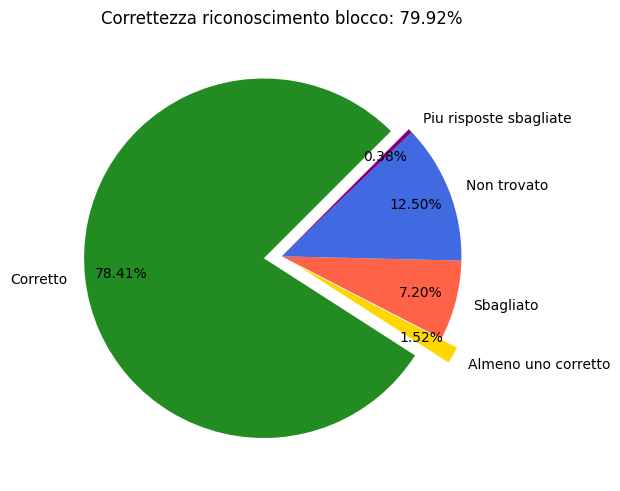

correct=78.4090909090909%, too much = 1.5151515151515151%
264


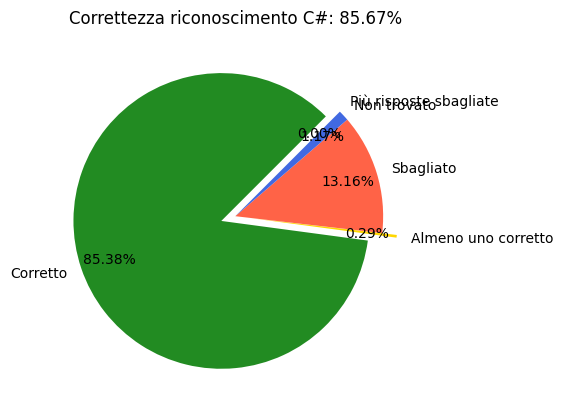

correct=83.33333333333333%, too much = 0.29239766081871343%
342


In [16]:
total = {
    "Corretto" : len(correct),
    "Almeno uno corretto" : len(too_much_correct),
    "Sbagliato" : len(wrong),
    "Non trovato" : len(not_found),
    "Piu risposte sbagliate": len(too_much_wrong),
}

colors = ["forestgreen","gold", "tomato", "royalblue", "purple", ]
explode = [0.1, 0.1, 0, 0, 0]

tot = sum(list(total.values()))
cor = len(correct)
too = len(too_much_correct)

fig, ax = plt.subplots(constrained_layout=True)
ax.pie(x=list(total.values()), labels=list(total.keys()), 
       autopct="%1.2f%%", 
       pctdistance=0.8, 
       colors=colors,
       explode=explode,
       startangle=45)
plt.title(f"Correttezza riconoscimento blocco: {((cor + too) * 100 / tot):.2f}%")

plt.show()


print(f"correct={cor * 100 / tot}%, too much = {too * 100 / tot}%")
print(tot)

c = {
    "Corretto" : 292,
    "Almeno uno corretto" : 1,
    "Sbagliato" : 45,
    "Non trovato" : 4,
    "Più risposte sbagliate" : 0
}
"""{
    "Corretto" : 285,
    "Almeno uno corretto" : 1,
    "Sbagliato" : 38,
    "Non trovato" : 34,
    "Più risposte sbagliate" : 0
}"""
tot = sum(list(c.values()))

plt.pie(x=list(c.values()),labels=list(c.keys()),
        autopct="%1.2f%%", 
       pctdistance=0.8, 
       colors=colors,
       explode=explode,
       startangle=45)

plt.title(f"Correttezza riconoscimento C#: {293 * 100 / tot:.2f}%")
plt.show()


print(f"correct={285 * 100 / tot}%, too much = {1 * 100 / tot}%")
print(tot)


In [20]:
not_found_numbers = set([x["expected"] for x in not_found])
found_numbers = set([x["expected"] for x in correct])
wrong_numbers = set([x["expected"] for x in wrong])
too_much_correct_numbers = set([x["expected"] for x in too_much_correct])
too_much_wrong_numbers = set([x["expected"] for x in too_much_wrong])
print(found_numbers)
print(not_found_numbers)
print(wrong_numbers)
print(too_much_correct_numbers)
print(too_much_wrong_numbers)
from pprint import pprint
pprint(correct)

{1, 2, 3, 7, 13, 18, 19, 20, 25, 43, 48, 53, 54, 57, 58, 80, 83, 86, 90, 111, 115, -1}
{1, 2, 3, 7, 43, 48, 86, 57, 58, 59}
{111, 48, 18, 115, 19, 54, 57, 58, 59, -1}
{25, 111}
{25}
[{'bounds': [1111, 495, 1840, 713], 'expected': 3, 'found': [3]},
 {'bounds': [266, 522, 993, 730], 'expected': 54, 'found': [54]},
 {'bounds': [0, 611, 143, 769], 'expected': -1, 'found': []},
 {'bounds': [633, 509, 1391, 742], 'expected': 58, 'found': [58]},
 {'bounds': [0, 554, 359, 758], 'expected': 115, 'found': [115]},
 {'bounds': [0, 539, 575, 763], 'expected': 115, 'found': [115]},
 {'bounds': [2261, 449, 2557, 659], 'expected': -1, 'found': []},
 {'bounds': [1090, 496, 1841, 726], 'expected': 58, 'found': [58]},
 {'bounds': [1313, 488, 2071, 711], 'expected': 58, 'found': [58]},
 {'bounds': [59, 535, 579, 747], 'expected': 115, 'found': [115]},
 {'bounds': [277, 521, 996, 722], 'expected': 115, 'found': [115]},
 {'bounds': [490, 515, 1205, 715], 'expected': 115, 'found': [115]},
 {'bounds': [0, 619

[{'bounds': [1111, 495, 1840, 713], 'expected': 3, 'found': [3]}, {'bounds': [266, 522, 993, 730], 'expected': 54, 'found': [54]}, {'bounds': [0, 611, 143, 769], 'expected': -1, 'found': []}, {'bounds': [633, 509, 1391, 742], 'expected': 58, 'found': [58]}, {'bounds': [0, 554, 359, 758], 'expected': 115, 'found': [115]}, {'bounds': [0, 539, 575, 763], 'expected': 115, 'found': [115]}, {'bounds': [2261, 449, 2557, 659], 'expected': -1, 'found': []}, {'bounds': [1090, 496, 1841, 726], 'expected': 58, 'found': [58]}, {'bounds': [1313, 488, 2071, 711], 'expected': 58, 'found': [58]}, {'bounds': [59, 535, 579, 747], 'expected': 115, 'found': [115]}, {'bounds': [277, 521, 996, 722], 'expected': 115, 'found': [115]}, {'bounds': [490, 515, 1205, 715], 'expected': 115, 'found': [115]}, {'bounds': [0, 619, 244, 786], 'expected': -1, 'found': []}, {'bounds': [1753, 445, 2555, 691], 'expected': 58, 'found': [58]}, {'bounds': [1973, 459, 2553, 676], 'expected': 58, 'found': [58]}, {'bounds': [0, 54

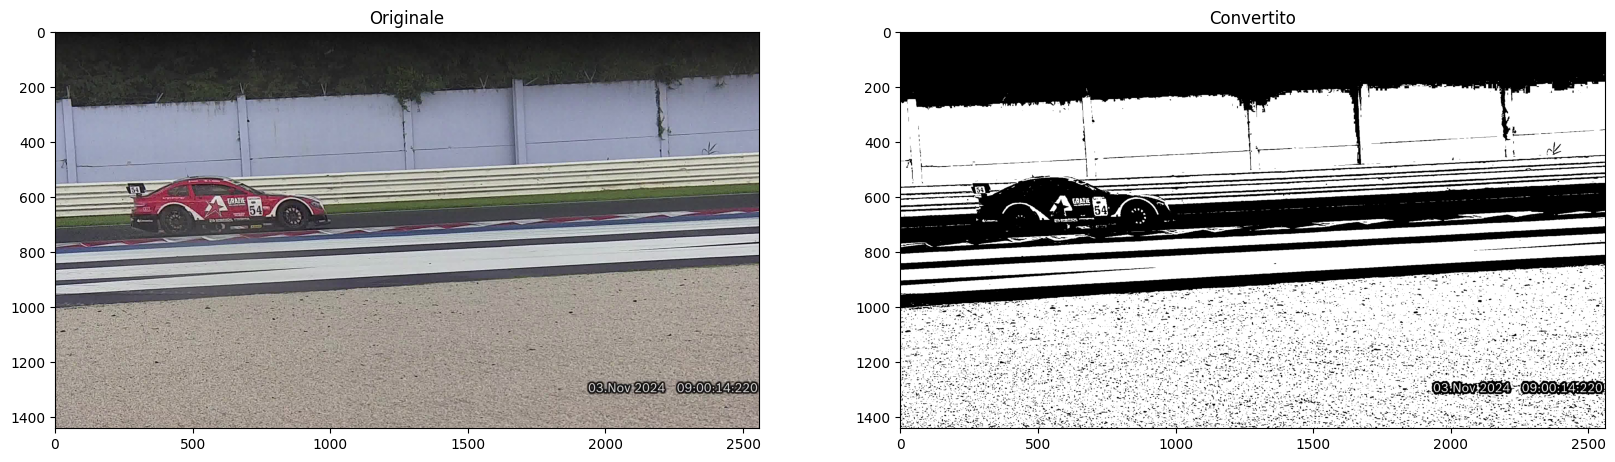

ratio > 2: 3.4951923076923075


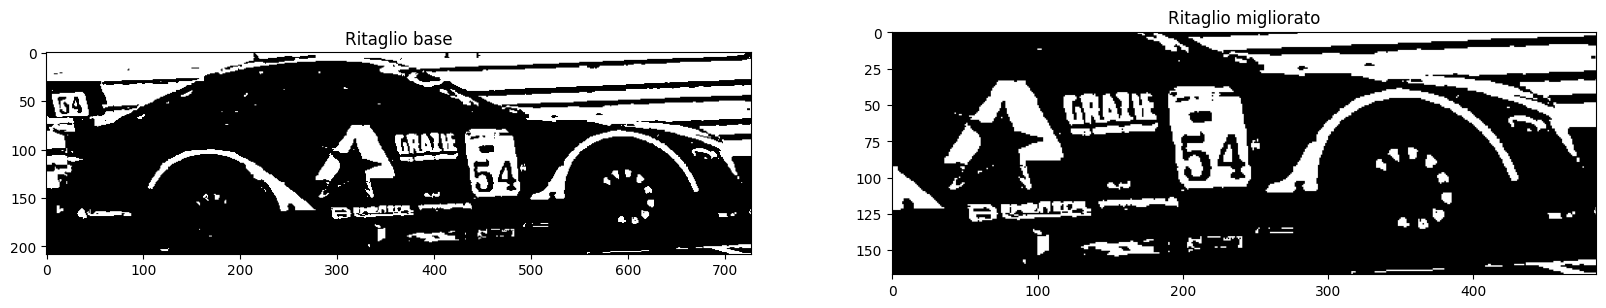

angle: -3.0929603576660156
angle: -3.465291976928711
square ratio 1.2452830188679245


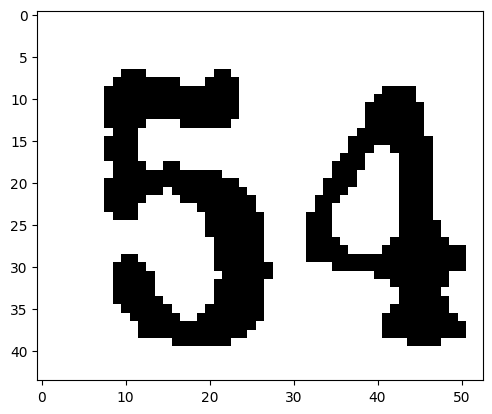

54


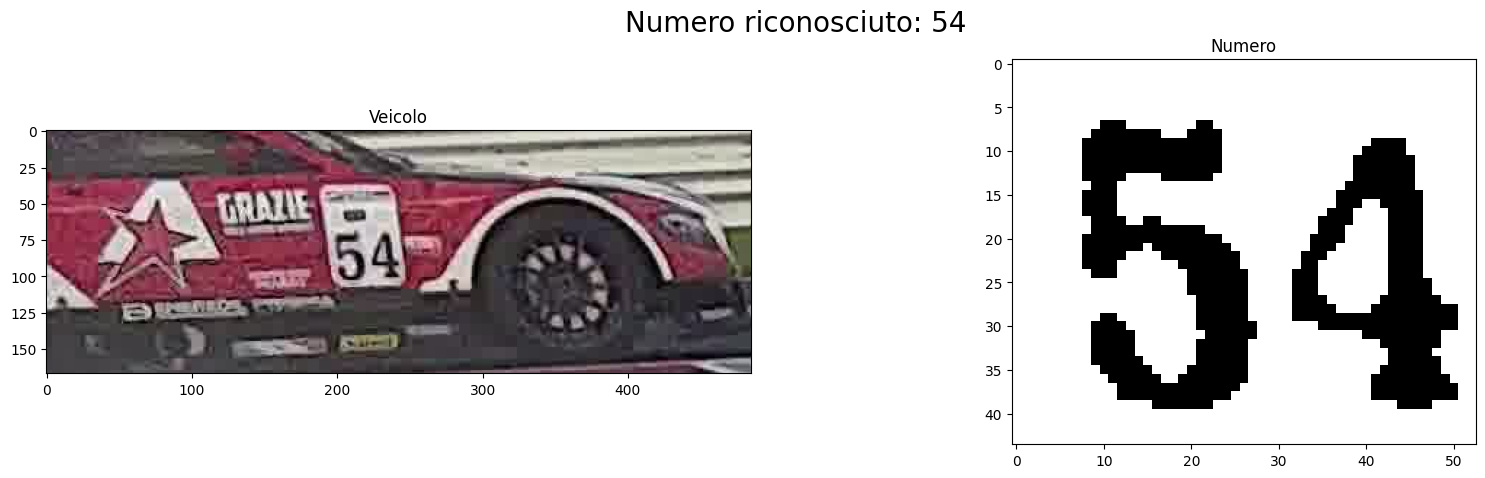

square ratio 1.171875


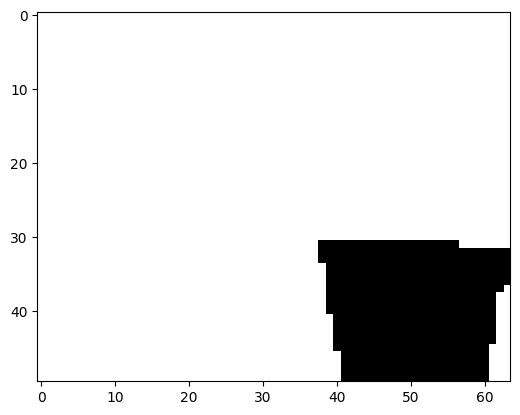

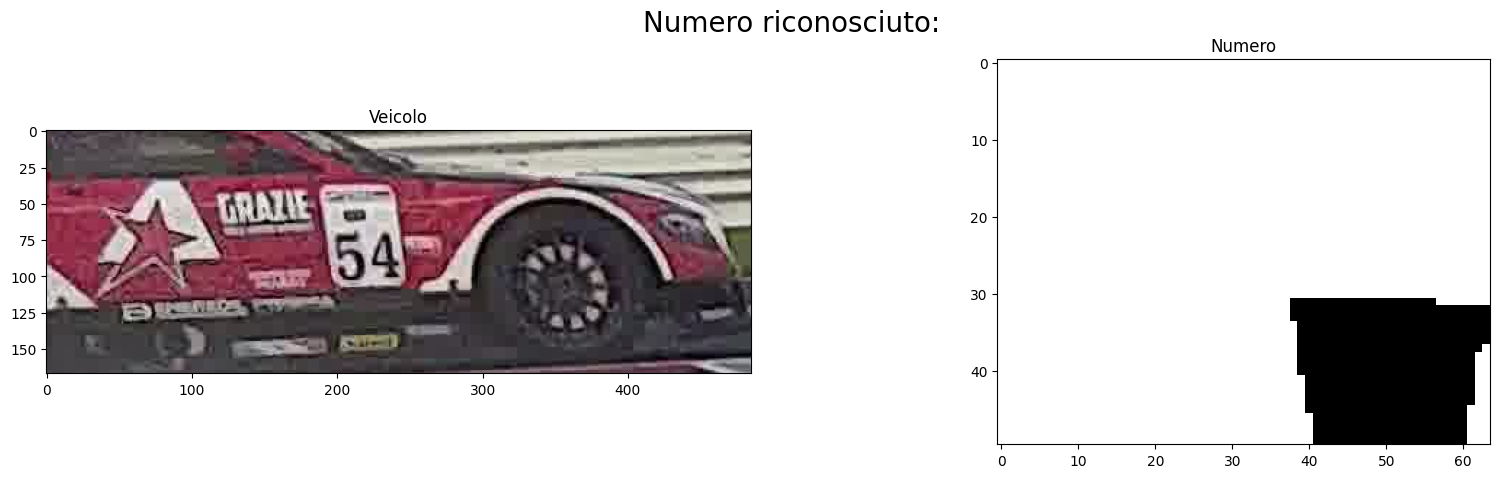

[54]


In [22]:
interesting = correct
print(interesting)
test = interesting[1]
print(test)
test_img = cv2.imread( "C:\\Users\\michi\\Desktop\\riconoscimento_numeri\\vids\\corti\\frames\\video1\\10.jpeg")

    
#test_img = cv2.cvtColor(test_img, cv2.COLOR_BGR2RGB)

test_hsv = cv2.cvtColor(test_img, cv2.COLOR_BGR2HSV)
def onclick(event):
    # Verifica che il click sia avvenuto all'interno dell'area dell'immagine
    if event.xdata is not None and event.ydata is not None:
        # Converte le coordinate in interi (coordinate pixel)
        x, y = int(event.xdata), int(event.ydata)
        # Estrai il valore del pixel (se l'immagine è a colori, sarà un array [R, G, B])
        pixel_val = test_hsv[y, x]
        print(f"Valore del pixel in ({x}, {y}): {pixel_val}")

x1, y1, x2, y2 = test["bounds"]


width = x2 - x1
height = y2 - y1
print((0,0,137),(179,62,255))

lower_white = np.array((0,0,137))
upper_white = np.array((179,62,255))

thres = cv2.inRange(test_hsv, lower_white, upper_white)

fig, ax = plt.subplots(1, 2, figsize=(20,20))

cut = thres[y1:y2, x1:x2]
cut_img = test_img[y1:y2, x1:x2]
ax[0].imshow(cv2.cvtColor(test_img, cv2.COLOR_BGR2RGB))
ax[0].set_title("Originale")
ax[1].imshow(thres, "gray")
ax[1].set_title("Convertito")
plt.show()


fig, ax = plt.subplots(1, 2, figsize=(20,20))
ax[0].imshow(cut, "gray")
ax[0].set_title("Ritaglio base")

if width / height >= 2 and x1 != 0:
    print("ratio > 2:", width / height)
    middle = x1 + (width // 3)
    last_quarter = x2 - (width // 5)

    top = height // 5

    cut = thres[y1 + top:y2, middle:x2]
    cut_img = test_img[y1 + top:y2, middle:x2]
    test_hsv = test_hsv[y1 + top:y2, middle:x2]
else:
    cut = thres[y1:y2, x1:x2]
    cut_img = test_img[y1:y2, x1:x2]


ax[1].imshow(cut, "gray")
ax[1].set_title("Ritaglio migliorato")
plt.show()
squares = calc_epsilon(cut, cut)

found_numbers = []
for square in squares:
    (height, width) = square.shape[:2]
    print("square ratio", height / width)
    if height / width > 1.1:
        square = square[height//3:]
    

    result = apply_filters(square)


    plt.imshow(result, "gray")
    plt.show()
    text = pytesseract.image_to_string(result, config=test_yolo.custom_oem_psm_config)
    text = text.strip()
    
    print(text)
    fig, ax = plt.subplots(1, 2, figsize=(20,5))

    ax[0].imshow(cv2.cvtColor(cut_img, cv2.COLOR_BGR2RGB))
    ax[0].set_title("Veicolo")

    ax[1].set_title("Numero")
    ax[1].imshow(result, "gray")
    fig.suptitle(f"Numero riconosciuto: {text}", fontsize=20)
    plt.show()

    if text != "":
            try:
                text = int(text)
                found_numbers.append(text)
            except:
                   print("Can't find number", text)
                   print(traceback.format_exc())

if len(found_numbers) == 0 and expected != -1:
    print("checking image")

    fig,  ax = plt.subplots(1, 2, figsize=(10,2))

    ax[0].imshow(cut, "gray")
    ax[0].set_title("Originale")

    kernel = np.ones((2, 3), np.uint8)  # Kernel orizzontale per rimuovere linee verticali
    cut = cv2.morphologyEx(cut, cv2.MORPH_CLOSE, kernel)

    ax[1].imshow(cut, "gray")
    ax[1].set_title("Ripulito")

    plt.show()
    
    fig, ax = plt.subplots(1, 2, figsize = (10, 2))

    ax[0].imshow(cut, "gray")
    ax[0].set_title("Prima")

    cut = remove_imperfections(cut)

    ax[1].imshow(cut, "gray")
    ax[1].set_title("Dopo")

    plt.show()

    contours, _ = cv2.findContours(cut, cv2.RETR_LIST, cv2.CHAIN_APPROX_NONE)
    conv = cv2.cvtColor(cut, cv2.COLOR_GRAY2RGB)
    filtered = []

    plt.imshow(conv)
    plt.show()

    
    conv = cv2.drawContours(conv, contours, -1, (255,0,0))

    to_remove = []


    pre_merge = conv.copy()
    for c in contours:
        x, y, w, h = cv2.boundingRect(c)
        print("contour ratio:", h / w)
        if h / w >= 1.2:
            pre_merge = cv2.rectangle(pre_merge, (x, y), (x+w, y+h), (0, 255,0))
            filtered.append(c)
        else:
            pre_merge = cv2.rectangle(pre_merge, (x, y), (x+w, y+h), (255,0,0))
    plt.imshow(pre_merge)
    plt.title("Filtro in base al rateo")
    plt.show()

    filtered = merge_contours(filtered, 10)
    for c in filtered:
        x, y, w, h = cv2.boundingRect(c)
        conv = cv2.rectangle(conv, (x, y), (x+w, y+h), (0,255,0))
    while len(found_numbers) == 0 and len(filtered) != 0:
        print(len(filtered))
        largest = get_largest_contour(filtered)
        x, y, w, h = cv2.boundingRect(largest)
        cut_largest = cut[y:y+h, x:x+w]

        fig, ax = plt.subplots(1, 3, figsize = (10, 2))

        ax[0].imshow(cut_largest ,"gray")
        ax[0].set_title("Base")

        border_size = 15
        cut_largest = cv2.copyMakeBorder(cut_largest, border_size, border_size, border_size, border_size, 
                                            cv2.BORDER_CONSTANT, value=255)

        ax[1].imshow(cut_largest, "gray")
        ax[1].set_title("Con bordo")

        kernel = np.ones((2,2))

        cut_largest = cv2.dilate(cut_largest, kernel)

        ax[2].imshow(cut_largest, "gray")
        ax[2].set_title("Dilatato")

        plt.show()
        
        fig, ax = plt.subplots(1, 2, figsize=(8, 2))

        ax[0].imshow(cv2.cvtColor(cut_img, cv2.COLOR_BGR2RGB))
        ax[0].set_title("Veicolo")

        ax[1].set_title("Numero")
        ax[1].imshow(cut_largest, "gray")

        plt.show()
        if w > 20 and h > 20:
            data = pytesseract.image_to_data(cut_largest, config=test_yolo.custom_oem_psm_config, output_type=pytesseract.Output.DICT)

            print(data)
            for i in range(len(data['text'])):
                if int(data['conf'][i]) >= 50:
                    print("found with conf", data["conf"][i])
                    found_numbers.append(int(data["text"][i]))
        
        filtered = [c for c in filtered if not np.array_equal(c, largest)]

        

print(found_numbers)

In [23]:
def taglia(x1, x2, y1, y2):
    taglio = cut_img[y1:y2, x1:x2]
    plt.imshow(taglio)
    plt.show()

    convert = cv2.cvtColor(taglio, cv2.COLOR_BGR2HSV)
    h = []
    s = []
    v = []
    for row in convert:
        for col in row:
            h.append(col[0])
            s.append(col[1])
            v.append(col[2])

    print(min(h), max(h))
    print(min(s), max(s))
    print(min(v), max(v))

(height, width) = cut_img.shape[:2]

x1 = IntSlider(min=0, max= width - 2, value=46 )
x2 = IntSlider(min=1, max= width - 1, value=97 )

y1 = IntSlider(min=0, max= height - 2, value=33 )
y2 = IntSlider(min=1, max= height - 1 , value=87 )

from ipywidgets import interact

interact(taglia, x1=x1, x2=x2, y1=y1, y2=y2)

interactive(children=(IntSlider(value=46, description='x1', max=483), IntSlider(value=97, description='x2', ma…

<function __main__.taglia(x1, x2, y1, y2)>

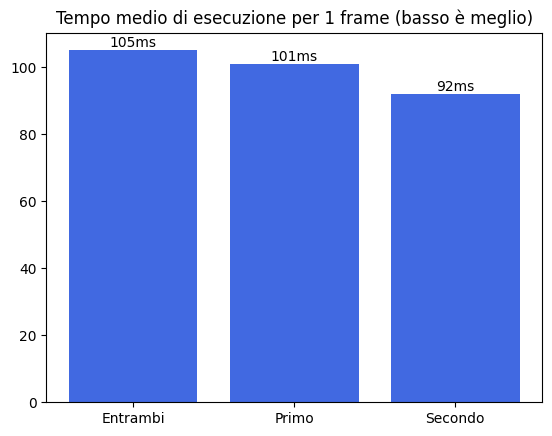

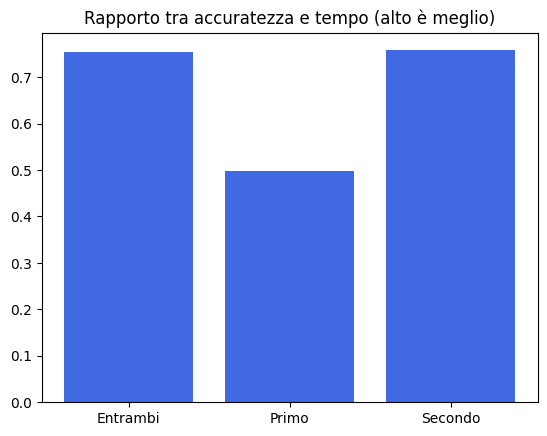

In [24]:
labels = ["Entrambi", "Primo", "Secondo"]

vals = np.array([105, 101, 92])
accs = np.array([79.17, 50.38, 69.70])
fig, ax = plt.subplots()

bars = ax.bar(labels, vals, color="royalblue")
ax.bar_label(bars, fmt="%dms")
plt.title("Tempo medio di esecuzione per 1 frame (basso è meglio)")
plt.show()


fig, ax = plt.subplots()
bars = ax.bar(labels, accs / vals, color="royalblue")

plt.title("Rapporto tra accuratezza e tempo (alto è meglio)")
plt.show()